# Import Libraries

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
import sys
import os

# Add the parent directory of 'src' to the path
sys.path.append(os.path.abspath('..'))

In [16]:
import random
from copy import deepcopy
from lib.Projectsolution import Solution
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import matplotlib.pyplot as plt


In [17]:
import importlib
import lib.genetic_algorithm
import lib.crossover
import lib.mutation
import lib.fitness
import lib.selection
import lib.Projectsolution

importlib.reload(lib.genetic_algorithm)
importlib.reload(lib.crossover)
importlib.reload(lib.mutation)
importlib.reload(lib.fitness)
importlib.reload(lib.selection)
importlib.reload(lib.Projectsolution)

from lib.genetic_algorithm import genetic_algorithm
from lib.crossover import pmx_crossover, order_crossover
from lib.mutation import swap_mutation, inversion_mutation, insertion_mutation, prime_slot_mutation, slot_shuffle_mutation
from lib.fitness import fitness
from lib.selection import tournament_selection, ranking_selection
from lib.Projectsolution import Solution



# Import Data

In [5]:
# Load artists data
artists_df = pd.read_csv(r"C:\Users\anama\OneDrive\Ambiente de Trabalho\Mestrado\S2\CIFO\data\artists(in).csv")

# Preview the first few rows
print(artists_df.head())

print(f"\n Number of artists: {len(artists_df)}")

   Unnamed: 0             name       genre  popularity
0           0    Midnight Echo        Rock          75
1           1      Solar Flare  Electronic          78
2           2     Velvet Pulse        Jazz          35
3           3     Neon Reverie  Electronic         100
4           4  The Silver Owls   Classical          85

 Number of artists: 35


In [6]:
# Rename the column
artists_df.rename(columns={"Unnamed: 0": "id"}, inplace=True)

# Confirm the change
print(artists_df.head())

   id             name       genre  popularity
0   0    Midnight Echo        Rock          75
1   1      Solar Flare  Electronic          78
2   2     Velvet Pulse        Jazz          35
3   3     Neon Reverie  Electronic         100
4   4  The Silver Owls   Classical          85


In [7]:
artists_df['genre_code'], genre_uniques = pd.factorize(artists_df['genre'])

print(artists_df[['genre', 'genre_code']].head())

        genre  genre_code
0        Rock           0
1  Electronic           1
2        Jazz           2
3  Electronic           1
4   Classical           3


In [8]:
# Normalize the 'popularity' column 
popularity = artists_df[['popularity']].values  
scaler = MinMaxScaler()
artists_df['popularity_norm'] = scaler.fit_transform(popularity)


In [9]:
class Artist:
    def __init__(self, id, name, popularity, genre, genre_code, popularity_norm):
        self.id = id
        self.name = name
        self.popularity = popularity
        self.genre = genre
        self.genre_code = genre_code
        self.popularity_norm = popularity_norm

    def __repr__(self):
        return f"{self.name} (Pop: {self.popularity}, Genre: {self.genre}, NormPop: {self.popularity_norm})"


# Convert to list of Artist objects
artists = [
    Artist(row["id"], row["name"], row["popularity"], row["genre"], row["genre_code"], row['popularity_norm'])
    for _, row in artists_df.iterrows()
]

In [10]:
# Try to load with headers and index
conflict_df = pd.read_csv(r"C:\Users\anama\OneDrive\Ambiente de Trabalho\Mestrado\S2\CIFO\data\conflicts(in).csv", index_col=0)

# Convert to NumPy matrix for easier computation later
conflict_matrix = conflict_df.to_numpy()

# Check matrix size
print("Conflict matrix shape:", conflict_matrix.shape)

Conflict matrix shape: (35, 35)


In [11]:
conflict_matrix[:5, :5]  

array([[0. , 0. , 0. , 0.2, 0.5],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0.5],
       [0.2, 1. , 1. , 0. , 0.2],
       [0.5, 0. , 0.5, 0.2, 0. ]])

In [12]:
artists_df.head()

,id,name,genre,popularity,genre_code,popularity_norm
0,0,Midnight Echo,Rock,75,0,0.6875
1,1,Solar Flare,Electronic,78,1,0.7250
2,2,Velvet Pulse,Jazz,35,2,0.1875
3,3,Neon Reverie,Electronic,100,1,1.0000
4,4,The Silver Owls,Classical,85,3,0.8125


# Tests

In [13]:
artist_ids = list(artists_df['id'])

In [14]:
fitness_history = []

Testing crossover: pmx, mutation: insertion, selection: tournament_selection
Best fitness: 0.9363


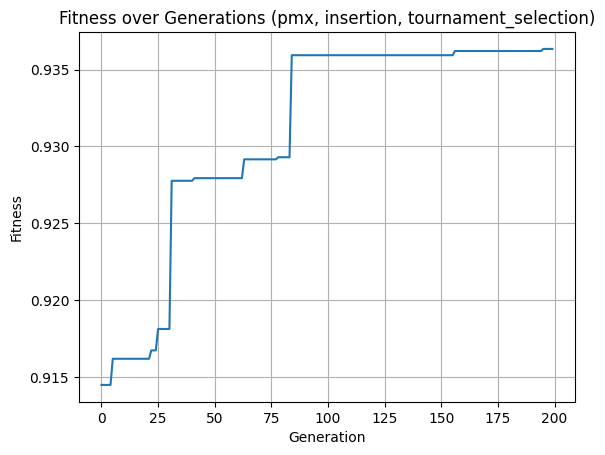

Testing crossover: pmx, mutation: insertion, selection: ranking_selection
Best fitness: 0.8895


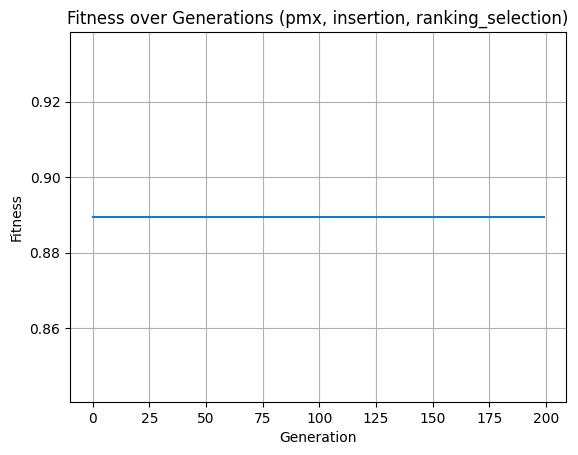

Testing crossover: pmx, mutation: prime, selection: tournament_selection
Best fitness: 0.9269


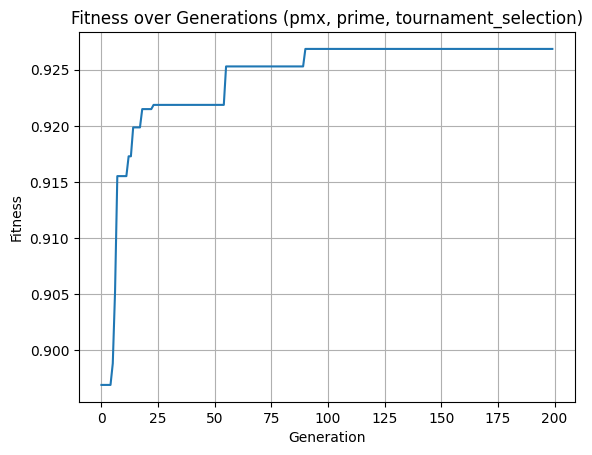

Testing crossover: pmx, mutation: prime, selection: ranking_selection
Best fitness: 0.8876


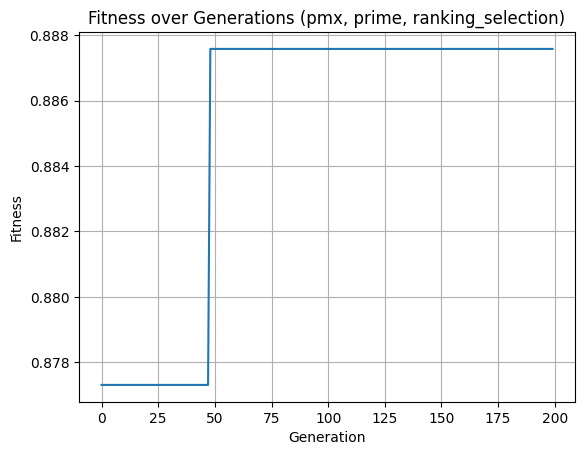

Testing crossover: pmx, mutation: shuffle, selection: tournament_selection
Best fitness: 0.8969


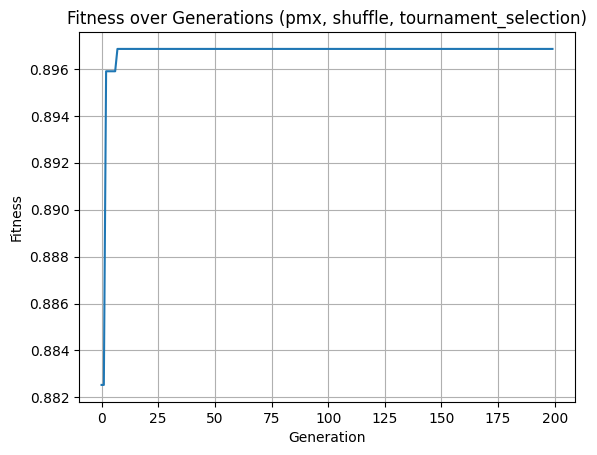

Testing crossover: pmx, mutation: shuffle, selection: ranking_selection
Best fitness: 0.8964


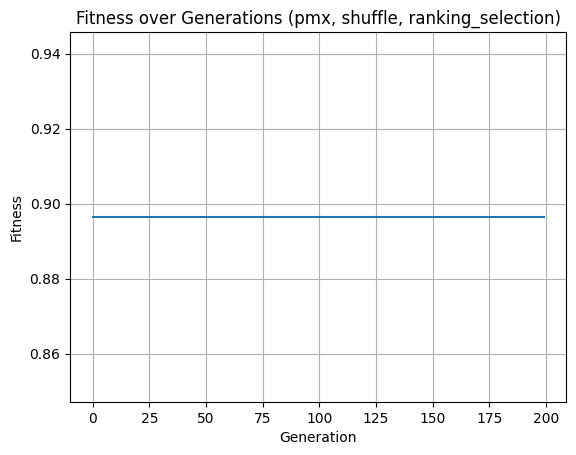

Testing crossover: ox, mutation: insertion, selection: tournament_selection
Best fitness: 0.9450


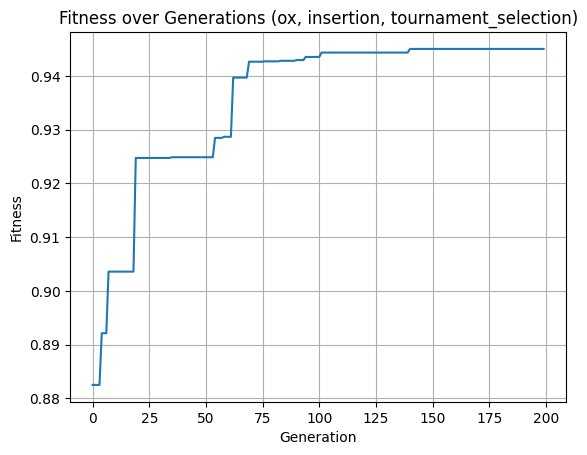

Testing crossover: ox, mutation: insertion, selection: ranking_selection
Best fitness: 0.8805


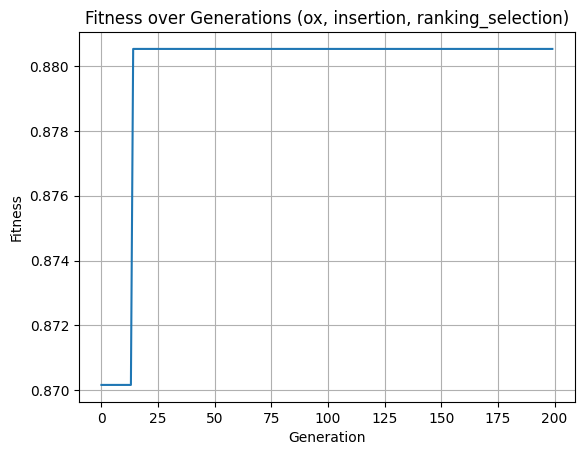

Testing crossover: ox, mutation: prime, selection: tournament_selection
Best fitness: 0.9361


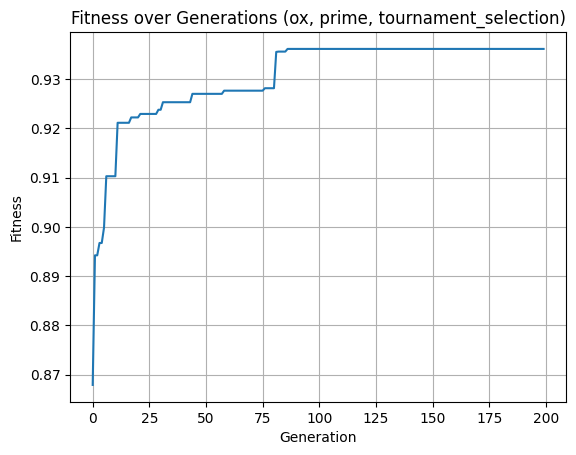

Testing crossover: ox, mutation: prime, selection: ranking_selection
Best fitness: 0.8784


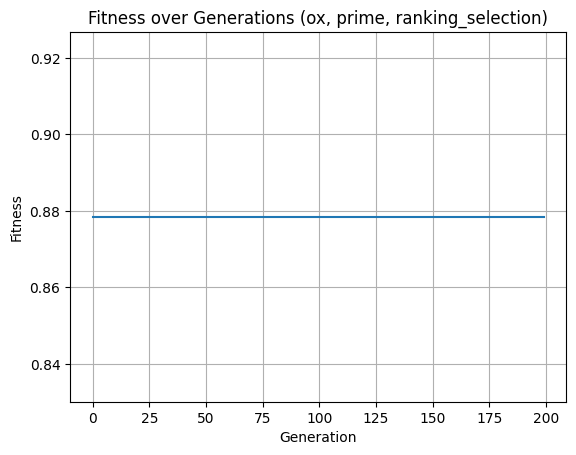

Testing crossover: ox, mutation: shuffle, selection: tournament_selection
Best fitness: 0.9238


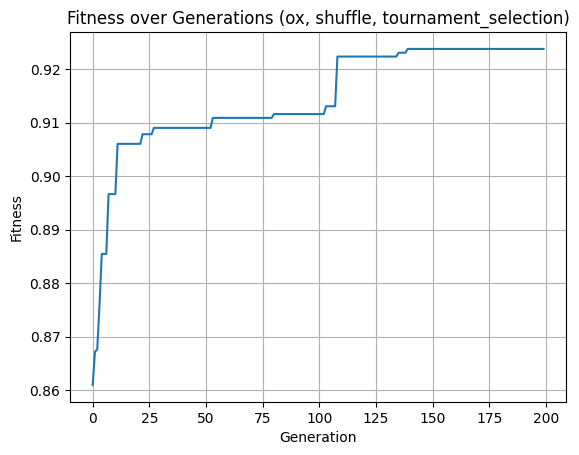

Testing crossover: ox, mutation: shuffle, selection: ranking_selection
Best fitness: 0.9118


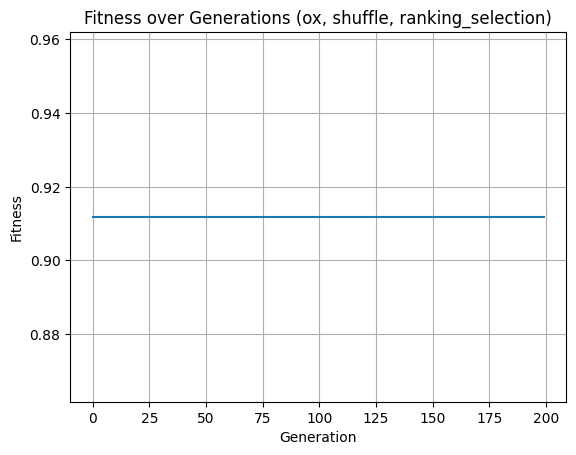


Best combination of parameters:
Crossover: ox
Mutation: insertion
Selection: tournament_selection

Best solution:

Fitness: 0.9450
[15, 30, 3, 18, 33, 24, 14, 31, 2, 32, 12, 10, 11, 9, 22, 7, 8, 21, 34, 5, 23, 1, 19, 27, 29, 6, 4, 13, 16, 17, 25, 28, 20, 0, 26]


In [18]:
# Define the methods for testing
crossover_methods = ['pmx', 'ox']
mutation_methods = ['insertion', 'prime','shuffle']
selection_methods = [tournament_selection, ranking_selection]

# Set crossover and mutation probabilities
xo_prob = 0.1
mut_prob = 0.05

# Initialize variables to track the best results
best_fitness = -float('inf')  # Start with a very low value
best_combination = None  # To store the best combination of parameters
best_solution = None  # To store the best solution

# Iterate through all combinations of parameters
for xo, mut, sel in product(crossover_methods, mutation_methods, selection_methods):
    print(f"Testing crossover: {xo}, mutation: {mut}, selection: {sel.__name__}")

    # Initialize the population for the current combination of parameters
    pop = [
        Solution(
            random.sample(artist_ids, len(artist_ids)),
            artists=artists,
            conflict_matrix=conflict_matrix,
            crossover_method=xo,
            mutation_method=mut
        )
        for _ in range(200) 
    ]

    # Run the genetic algorithm with the current population and parameters
    current_best_solution, fitness_over_time = genetic_algorithm(
        initial_population=pop,
        max_gen=200,
        selection_algorithm=sel,
        maximization=True,
        xo_prob=xo_prob,  
        mut_prob=mut_prob,  
        elitism=True,
        verbose=False,
        track_history=True # Track fitness per generation
    )

    # Get the fitness of the current best solution
    current_fitness = current_best_solution.fitness()

    print(f"Best fitness: {current_fitness:.4f}")

    # If the current fitness is better than the best fitness so far, update the best results
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_combination = (xo, mut, sel)
        best_solution = current_best_solution

    # Plot fitness over time to check convergence behavior
    plt.plot(fitness_over_time)
    plt.title(f"Fitness over Generations ({xo}, {mut}, {sel.__name__})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

# After the loop, print the best combination and the best solution
print("\nBest combination of parameters:")
print(f"Crossover: {best_combination[0]}")
print(f"Mutation: {best_combination[1]}")
print(f"Selection: {best_combination[2].__name__}")

# Print the best solution
print("\nBest solution:")
# Print the fitness of the best solution
print(f"\nFitness: {best_solution.fitness():.4f}")

# Print the solution (the order of artists)
print(best_solution)


In [21]:
# Number of stages and slots
num_stages = 5
num_slots = 7

# Get the best solution (list of indices)
best_artist_solution = [artists[i] for i in best_solution.representation]

# Create a 2D list (5 stages x 7 slots) to represent the schedule
schedule = [[None for _ in range(num_slots)] for _ in range(num_stages)]

# Fill the schedule with the artists based on the best solution
for stage in range(num_stages):
    for slot in range(num_slots):
        index = stage * num_slots + slot
        schedule[stage][slot] = best_artist_solution[index]

# Display the schedule
for stage in range(num_stages):
    print(f"Stage {stage + 1}:")
    for slot in range(num_slots):
        artist = schedule[stage][slot]
        print(f"  Slot {slot + 1}: {artist.name}, Popularity: {artist.popularity}, Genre: {artist.genre}")
    print()


Stage 1:
  Slot 1: Golden Ember, Popularity: 61, Genre: Rock
  Slot 2: Turbo Vortex, Popularity: 53, Genre: Rock
  Slot 3: Neon Reverie, Popularity: 100, Genre: Electronic
  Slot 4: Velvet Underground, Popularity: 72, Genre: Rock
  Slot 5: Cosmic Frequency, Popularity: 53, Genre: Rock
  Slot 6: Shadow Cadence, Popularity: 66, Genre: Jazz
  Slot 7: Synthwave Saints, Popularity: 94, Genre: Rock

Stage 2:
  Slot 1: The Jazz Nomads, Popularity: 64, Genre: Jazz
  Slot 2: Velvet Pulse, Popularity: 35, Genre: Jazz
  Slot 3: The Bassline Architects, Popularity: 61, Genre: Hip-Hop
  Slot 4: Blue Horizon, Popularity: 51, Genre: Pop
  Slot 5: The Wandering Notes, Popularity: 84, Genre: Jazz
  Slot 6: Phantom Groove, Popularity: 47, Genre: Hip-Hop
  Slot 7: Deep Resonance, Popularity: 90, Genre: Jazz

Stage 3:
  Slot 1: Quantum Beat, Popularity: 96, Genre: Hip-Hop
  Slot 2: Static Mirage, Popularity: 94, Genre: Rock
  Slot 3: Crimson Harmony, Popularity: 20, Genre: Classical
  Slot 4: Celestial Vo